In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

from plot_utils import plot_ground_truth_heatmap, plot_spike_grps

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

from sim_utils import load_regime_results, launch_regime_feat_sel, create_trial_jobs
from sim_utils import get_sim_params, get_sim_params
from sim_utils import generate_x_mtx, generate_spike_mtx
from plot_utils import plot_ground_truth_heatmap
from plot_utils import check_spike_groups, check_example_noise_matrix
def visualize_setup(sim_id, plot_mtx=False):
    check_spike_groups(sim_id)
    if plot_mtx:
        check_example_noise_matrix(sim_id, 0.2)
    df_regime = generate_regime_info(sim_id)
    # core simulation parameters
    logger.setLevel(logging.DEBUG)
    df_regime = get_regime_info(sim_id)
    display(df_regime.tail())
    display("Number of jobs to submit: {}".format(df_regime.shape[0]))

In [3]:
sim_id = "main_sim_6"
sim_params = get_sim_params(sim_id)
sim_params

{'seed': 1,
 'n_samps': 1500,
 'z_param': {'spike_grp': ['left', 'right'],
  'n_repetitions': 1,
  'rel_noise_list': [1, 0.1]},
 'x_param': {'spike_grp': ['right',
   'left',
   'mid',
   'mid_r',
   'multi_left',
   'multi_right'],
  'n_repetitions': None,
  'rel_noise_list': None,
  'seed_offset': 0},
 'n_trials': 100,
 'noise_levs': [0.1, 0.5, 1, 1.5, 2, 3],
 'sparsities': [0.05, 0.1, 0.2],
 'target_vars': 9000,
 'methods': ['unsup_pc', 'unsup_graph', 'pc', 'graph'],
 'graph_k': 10,
 'n_perms': 10000,
 'alpha': 0.05,
 'perm_method': 'pool',
 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_6',
 'save': True,
 'check_skip': False,
 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}}

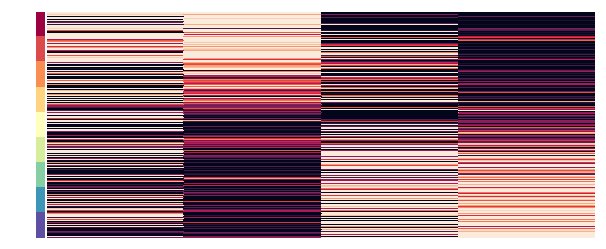

[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


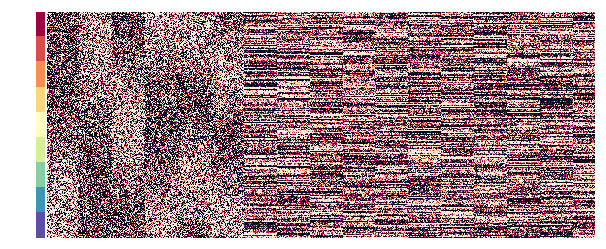

In [67]:
np.random.seed(sim_params["seed"])
lam_true = np.random.uniform(size=sim_params["n_samps"])
z, _ = generate_spike_mtx(lam_true, **sim_params["z_param"])
plot_ground_truth_heatmap(lam_true, z)

x_param = sim_params["x_param"]
x_param["rel_noise_list"] = [2]
x_param["n_repetitions"] = 150
x = generate_x_mtx(lam_true, x_param, sim_params)
plot_ground_truth_heatmap(lam_true, x[:,:2500])

In [68]:
# TODO:
# 1. run g-aloe on this to make sure the correct variables are selected
# 2. fit splines on the selected variables (using spline fit) -> feat_viz
# 3. collect the parameter matrix -> feat_viz
from main_methods import run_procedure, run_unsupervised, evaluate_result
from general_utils import evaluate_rejections

meth_params = {
    "method": "graph",
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
}
result = run_procedure(z, x, meth_params)
result.keys()

[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...


dict_keys(['lam_init', 'lam_update', 'p_vals', 'rejections'])

In [69]:
n_proto = len(x_param["spike_grp"])
n_rep = x_param["n_repetitions"]
nn_idx = np.arange(n_rep*n_proto)
rej_idx = result["rejections"]
mt_res = evaluate_rejections(set(rej_idx), set(nn_idx))
mt_res["Corr"] = abs(spearmanr(result["lam_update"], lam_true).correlation) 
mt_res

{'FDP': 0.017006802721088437,
 'Power': 0.3211111111111111,
 'Corr': 0.956917520407787}

In [70]:
# fit the spline with updated lambda and the x features
from spline_utils import setup_basis, spline_fit
zone_true = rank_and_bin(lam_true, n_bins=9)
lam = result["lam_update"]
y = x
var_labs = np.ones(x.shape[1]) * -1
for i in range(n_proto):
    var_labs[i*(n_rep): (i+1)*n_rep] = i
# y = x[:, rej_idx]
# var_labs = var_labs[rej_idx]

base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, y, base_args)

cr(x, knots=(-0.015, 0.012))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters


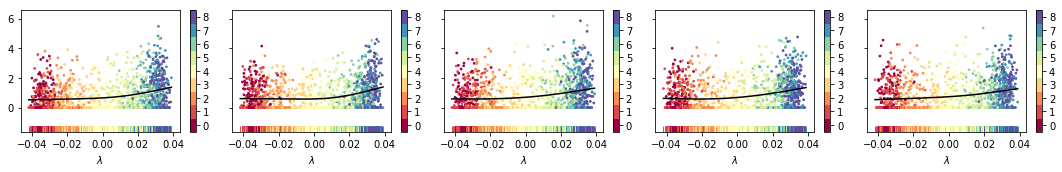

In [71]:
from general_utils import rank_and_bin
from plot_utils import plot_pcurve_fits
sel_idx = np.arange(5)
plt_mtx = y[:, sel_idx]
plot_pcurve_fits(plt_mtx, 
                 lam, 
                 p_fun, 
                 all_iterations=False, 
                 labels=zone_true)

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


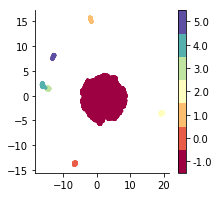

In [72]:
import umap
from plot_utils import plot_scatter_discrete
uobj = umap.UMAP(random_state=10101)
embedding = uobj.fit_transform(c_mtx)
fig, ax = plt.subplots(1,1, figsize=(3,3))
plot_scatter_discrete(embedding, var_labs, ax)
plt.show()

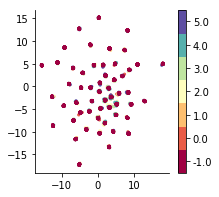

In [74]:
uobj = umap.UMAP(random_state=10101)
embedding = uobj.fit_transform(x.T)
fig, ax = plt.subplots(1,1, figsize=(3,3))
plot_scatter_discrete(embedding, var_labs, ax)
plt.show()

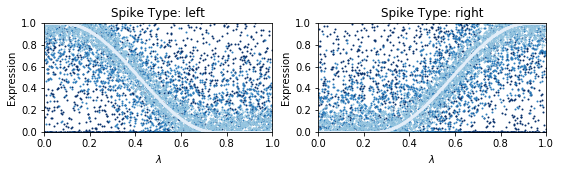

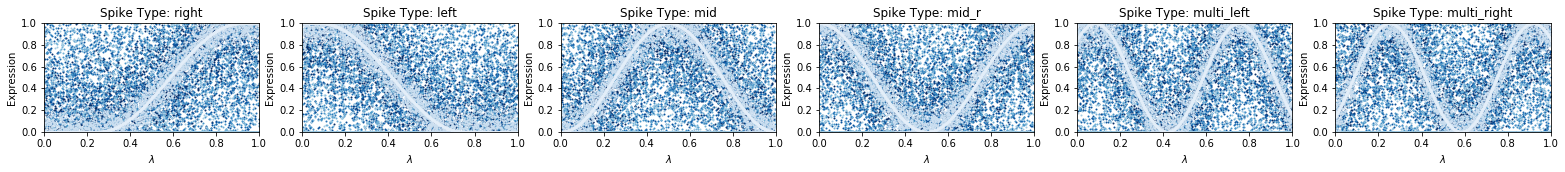

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


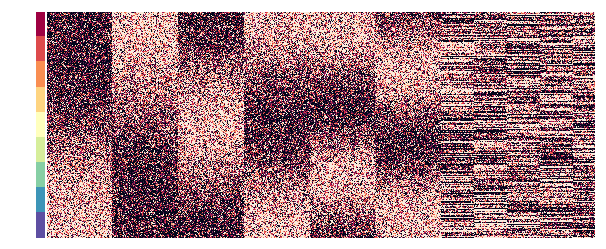

[feat_viz INFO] {'seed': 1, 'n_samps': 1500, 'z_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 1, 'rel_noise_list': [1, 0.1]}, 'x_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': None, 'rel_noise_list': None}, 'n_trials': 100, 'noise_levs': [0.1, 0.5, 1, 1.5, 2, 3], 'sparsities': [0.05, 0.1, 0.2], 'target_vars': 9000, 'methods': ['unsup_pc', 'unsup_graph', 'pc', 'graph'], 'graph_k': 10, 'n_perms': 10000, 'alpha': 0.05, 'perm_method': 'pool', 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_6', 'save': True, 'check_skip': False, 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}}
[feat_viz DEBUG] Data (length 17) saved as: /share/PI/sabatti/feat_viz/main_sim_6/param_all.json
[feat_viz DEBUG] Data (shape (18, 3)) saved as: /share/PI/sabatti/feat_viz/main_sim_6/regime_info.csv
[feat_viz INFO] Saved regimes to: /share/PI/sabatti/feat_viz/main_sim_6/regime_info.csv
[feat_viz DEBUG] Data (shape (18, 3)) loa

,n_samps,sparsity,noise_lev,Regime
13,1500,0.2,0.5,13
14,1500,0.2,1.0,14
15,1500,0.2,1.5,15
16,1500,0.2,2.0,16
17,1500,0.2,3.0,17


'Number of jobs to submit: 18'

In [10]:
visualize_setup(sim_id, plot_mtx=True)